In [1]:
from IPython.display import Image
import torch
import numpy as np
import pandas as pd
from torch import nn

# 1. Автоэнкодеры

Задача: мы хотим получить некоторое *сжатое* представление картинки (любого объекта) сохранив максимум информации.

## Концепция автоэнкодера

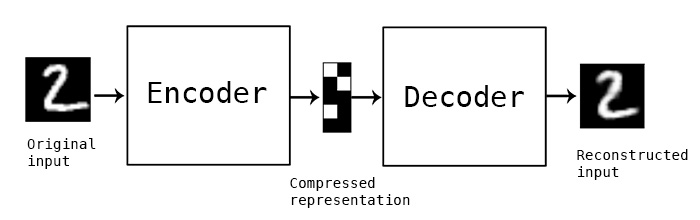

In [2]:
Image('images/auto1.jpeg', width=1200)

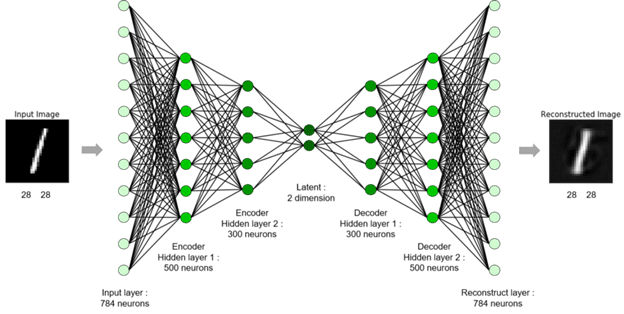

In [3]:
Image('images/auto2.png', width=1200)

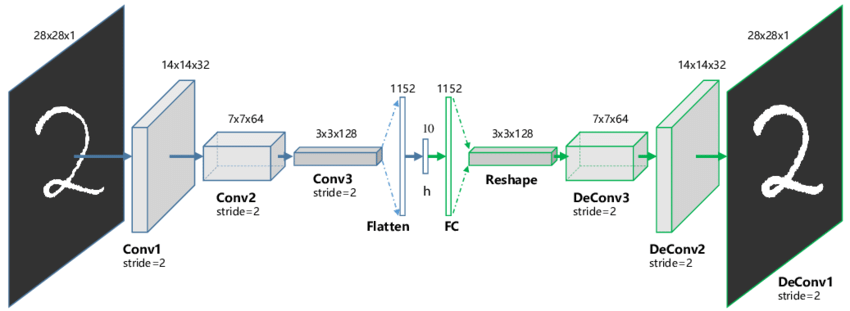

In [4]:
Image('images/auto3.png', width=1200)

Так, а что такое Deconv?:)

In [5]:
x = torch.ones(36, dtype=torch.float).reshape((1,3,3,4))

l = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3,3))

l(x)

tensor([[[[0.3577, 0.3577]]]], grad_fn=<ConvolutionBackward0>)

In [6]:
l.weight

Parameter containing:
tensor([[[[ 0.0641, -0.0923, -0.0432],
          [-0.1826, -0.0809,  0.0747],
          [ 0.1389, -0.0127, -0.0445]],

         [[ 0.1593, -0.0072, -0.1093],
          [ 0.1248,  0.0774, -0.0789],
          [ 0.1736,  0.1585, -0.0244]],

         [[-0.1616,  0.1110,  0.0768],
          [ 0.1631, -0.1281, -0.0581],
          [-0.0085,  0.0282, -0.1099]]]], requires_grad=True)

In [7]:
x = torch.ones(4, dtype=torch.float).reshape((1,2,2))
x

tensor([[[1., 1.],
         [1., 1.]]])

In [8]:
# deconv
l = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(3,3), bias=False)

l.weight = nn.Parameter(torch.ones_like(l.weight), requires_grad=False)

l(x)

tensor([[[1., 2., 2., 1.],
         [2., 4., 4., 2.],
         [2., 4., 4., 2.],
         [1., 2., 2., 1.]]])

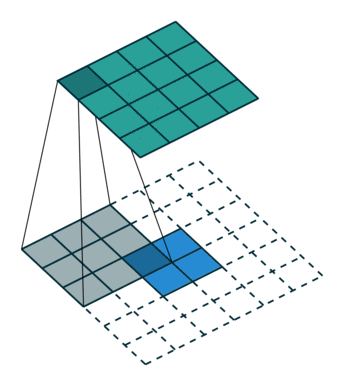

In [9]:
Image('images/deconv1.gif')

In [10]:
x = torch.ones(4, dtype=torch.float).reshape((1,2,2))

# deconv
l = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(3,3), bias=False)

l.weight = nn.Parameter(torch.ones_like(l.weight), requires_grad=False)

l(x)

tensor([[[1., 2., 2., 1.],
         [2., 4., 4., 2.],
         [2., 4., 4., 2.],
         [1., 2., 2., 1.]]])

In [11]:
x = torch.ones(4, dtype=torch.float).reshape((1,1,2,2))


# deconv
l = nn.ConvTranspose2d(in_channels=1, out_channels=1, 
                       kernel_size=(3,3), bias=False,
                       stride=2)

l.weight = nn.Parameter(torch.ones_like(l.weight), requires_grad=False)

l(x)

tensor([[[[1., 1., 2., 1., 1.],
          [1., 1., 2., 1., 1.],
          [2., 2., 4., 2., 2.],
          [1., 1., 2., 1., 1.],
          [1., 1., 2., 1., 1.]]]])

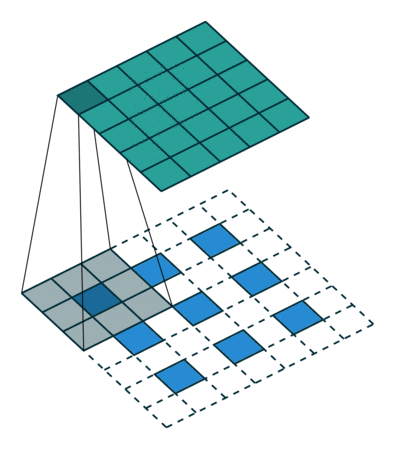

In [12]:
Image('images/deconv2.gif')

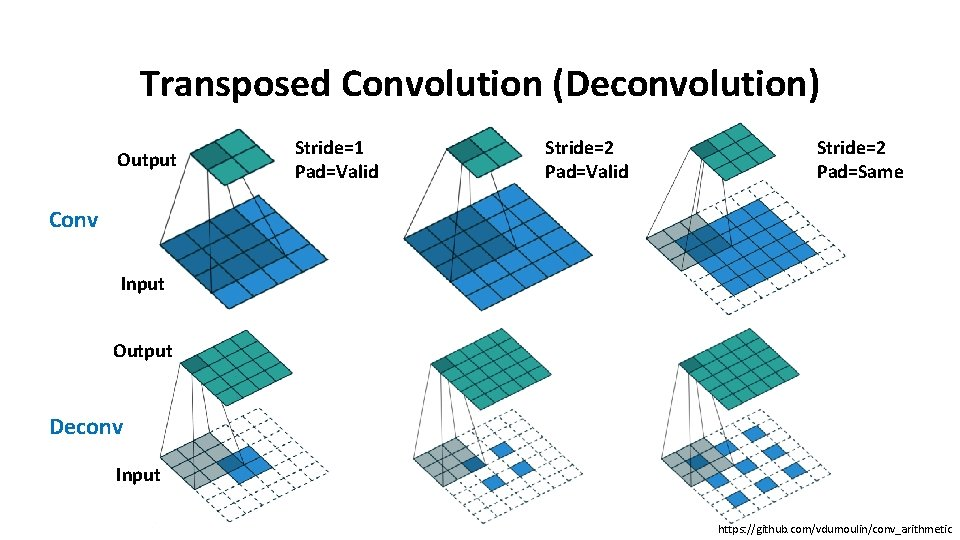

In [13]:
Image('images/deconv5.jpeg', width=600)

## А что с пуллингами?)

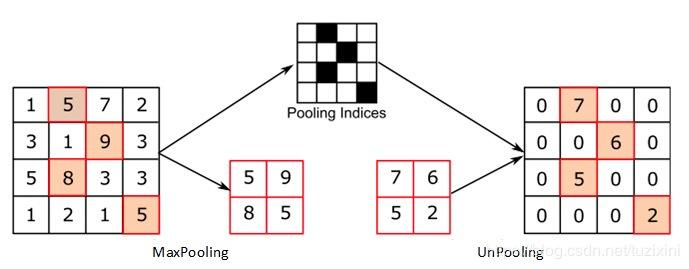

In [14]:
Image('images/deconv7.jpeg')

**Важно**: Сохраняем в памяти индексы, где стояли объекты, которые остались. А все остальное заполняем нулями.

## Import Torch and other libraries

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import time
import torchvision
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ExponentialLR
from IPython.display import clear_output
%matplotlib inline

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [16]:
# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transforms.ToTensor())

# Download and load the test data
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transforms.ToTensor())

x_train = torch.Tensor([x.numpy() for x, y in trainset][:20000])
x_test  = torch.Tensor([x.numpy() for x, y in testset ][:200])
y_test = testset.targets[:200]

/tmp/ipykernel_85971/788564944.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  x_train = torch.Tensor([x.numpy() for x, y in trainset][:20000])


In [17]:
train_set = torch.utils.data.TensorDataset(x_train, x_train)
train_set, val_set = torch.utils.data.random_split(train_set, [round(len(train_set) * 0.8), round(len(train_set) * 0.2)])
test_set = torch.utils.data.TensorDataset(x_test, x_test)

dataloaders = {
  'train': torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True),
  'val'  : torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False),
  'test' : torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)
}

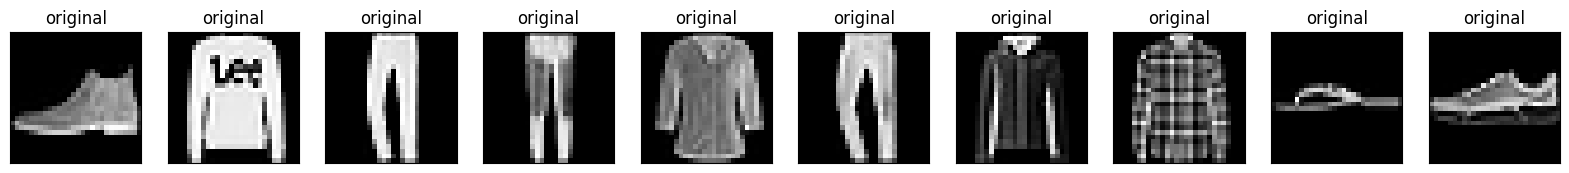

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i][0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Model


In [19]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [20]:
class Encoder(nn.Module):
    def __init__(self, latent_len=2):
        super(Encoder, self).__init__()
        self.latent_len = latent_len
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3))   #16x26x26
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3))  #16x24x24
        self.pool = nn.MaxPool2d(kernel_size=(2,2)) #16x2x2
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(2,2), stride=2) #16x6x6
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(2,2), stride=2) #16x3x3
        self.conv5 = nn.Conv2d(32, latent_len, kernel_size=(3,3)) #16x3x3    

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = Flatten()(x)
        #x = nn.Linear(16*3*3, 2)(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_len=2):
        super(Decoder, self).__init__()
        self.latent_len = latent_len
        self.conv0 = nn.ConvTranspose2d(latent_len, 32, kernel_size=(3,3))
        self.conv1 = nn.ConvTranspose2d(32, 32, kernel_size=(2,2), stride=2)
        self.conv2 = nn.ConvTranspose2d(32, 32, kernel_size=(2,2), stride=2)
        self.conv3 = nn.ConvTranspose2d(32, 32, kernel_size=(3,3))
        self.conv4 = nn.ConvTranspose2d(32, 1, kernel_size=(3,3))
        self.sigmoid_activation = torch.nn.Sigmoid()

    def forward(self, x):
        #x = nn.Linear(2, 16*3*3)(x)
        x = x.view(x.size(0), self.latent_len, 1, 1)
        x = F.leaky_relu(self.conv0(x))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = nn.Upsample(scale_factor=2)(x)
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.sigmoid_activation(x)
        return x

class Autoencoder(torch.nn.Module):
    def __init__(self, latent_len=2):
        super(Autoencoder, self).__init__()
        self.latent_len = latent_len
        self.encoder = Encoder(latent_len)
        self.decoder = Decoder(latent_len)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training

In [21]:
def train_epoch(model, dataloader, criterion, device, optimizer):
    total_loss = 0
    n = len(dataloader)    

    model.train(True)
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch.requires_grad = True
        
        out = model(X_batch)

        loss = criterion(out, y_batch)
        loss.backward()
        total_loss += loss.item()

        optimizer.step()
        optimizer.zero_grad()

    av_loss = total_loss / n

    return av_loss

In [22]:
@torch.no_grad()
def eval_model(model, dataloader, criterion, device):
    total_loss = 0
    n = len(dataloader)  
    
    model.eval()
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
 
        out = model(X_batch)
        loss = criterion(out, y_batch)
        total_loss += loss.item()
 
    av_loss = total_loss / n
 
    return av_loss

In [23]:
def draw_loss(log):
    clear_output(True)
    np_log = np.array(log)
    plt.title("Loss")
    plt.plot(np_log[:, 0], label='train')
    plt.plot(np_log[:, 1], label='val')
    plt.grid()
    plt.legend()
    plt.show()

In [24]:
def train_model(model, dataloaders, optimizer,
                criterion=nn.MSELoss(), 
                device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu'), 
                epochs=500):
    
    model = model.to(device)
    scheduler=ExponentialLR(optimizer, gamma=0.999)
    log_loss = []
    for epoch in range(epochs):
        start_time = time.time()
        
        #learning
        train_loss = train_epoch(model, dataloaders['train'], criterion, device, optimizer)       
        val_loss  =  eval_model(model, dataloaders['val'], criterion, device)
        scheduler.step()

        #logs
        #if epoch % 10 == 5:
        log_loss.append((train_loss, val_loss))
        draw_loss(log_loss)
        print("Epoch [{}/{}] Time: {:.2f}s; TrainLoss: {:.7f}; ValLoss: {:.7f};".format(
              epoch + 1, epochs, time.time() - start_time, train_loss, val_loss))

    
    return model

# Training

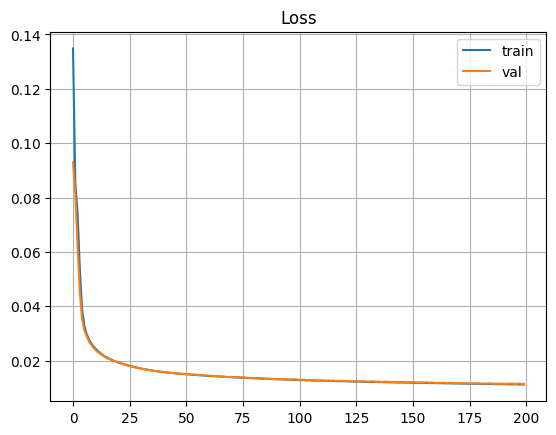

Epoch [200/200] Time: 0.86s; TrainLoss: 0.0112229; ValLoss: 0.0114508;


In [25]:
model = Autoencoder(latent_len=32)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
criterion=nn.MSELoss()
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

epochs=200

model = train_model(model, dataloaders, optimizer=optimizer, 
            criterion=criterion, 
            device=device, 
            epochs=epochs)

Now that the model is trained, let's test it by encoding and decoding images from the test set.

## Пример 1. Реконструкция изображения из сжатого представления

In [26]:
encoded_imgs = model.encoder(x_test.to(device))
decoded_imgs = model.decoder(encoded_imgs).cpu().detach().numpy()
encoded_imgs = encoded_imgs.cpu().detach().numpy()


In [27]:
encoded_imgs.shape

(200, 32)

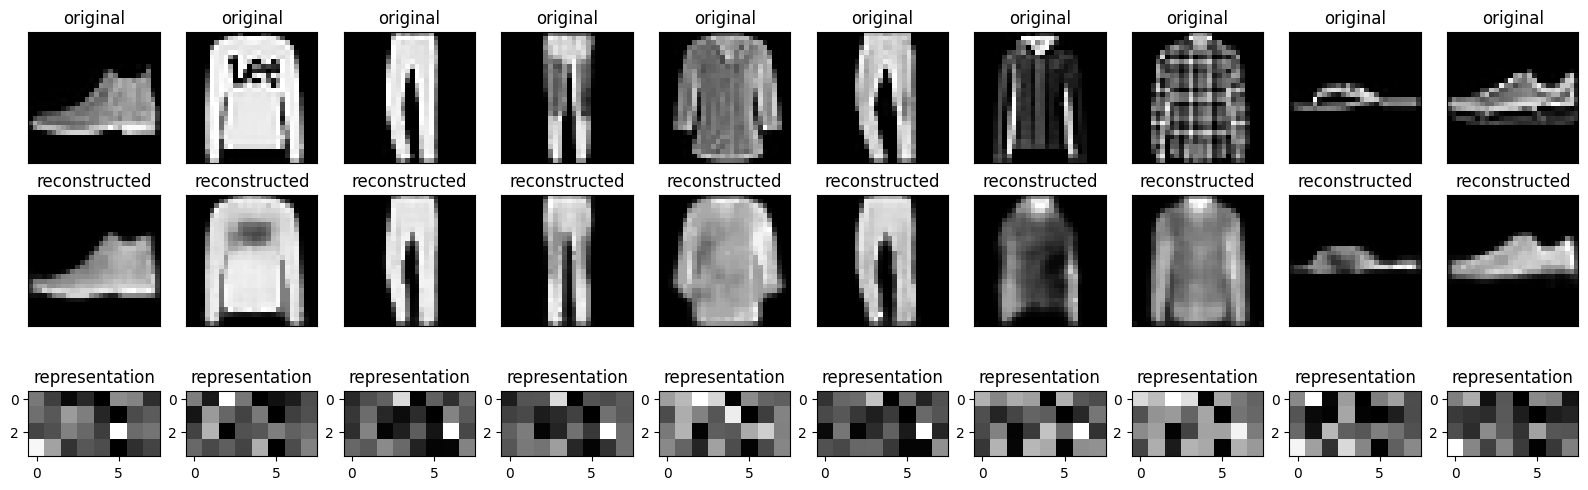

In [28]:
n = 10
fig, axes = plt.subplots(3,n,figsize=(20, 6))
for i in range(n):
  ax0, ax1, ax2 = axes[:,i]
  # display original
  ax0.imshow(x_test[i][0])
  ax0.set_title("original")
  ax0.get_xaxis().set_visible(False)
  ax0.get_yaxis().set_visible(False)

  # display reconstruction
  ax1.imshow(decoded_imgs[i][0])
  ax1.set_title("reconstructed")
  ax1.get_xaxis().set_visible(False)
  ax1.get_yaxis().set_visible(False)

  # display latent
  ax2.set_title("representation")
  ax2.imshow(encoded_imgs[i].reshape(4,8))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Пример 2, кластеризация, латентное пространство картинок 

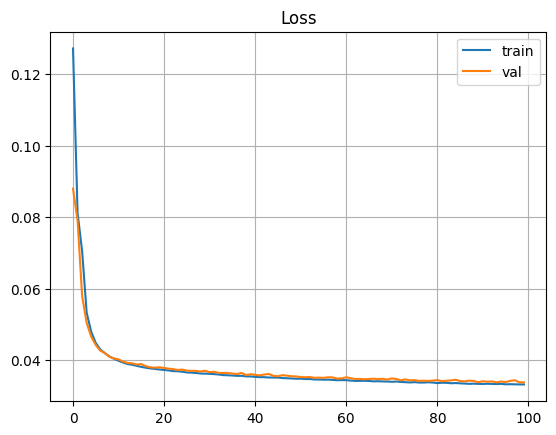

Epoch [100/100] Time: 0.84s; TrainLoss: 0.0331858; ValLoss: 0.0337713;


In [29]:
model2 = Autoencoder(latent_len=2)

optimizer = torch.optim.AdamW(model2.parameters())
criterion=nn.MSELoss()
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

epochs=100

model2 = train_model(model2, dataloaders, optimizer=optimizer, 
            criterion=criterion, 
            device=device, 
            epochs=epochs)

(10, 2)


/tmp/ipykernel_85971/3304718668.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))


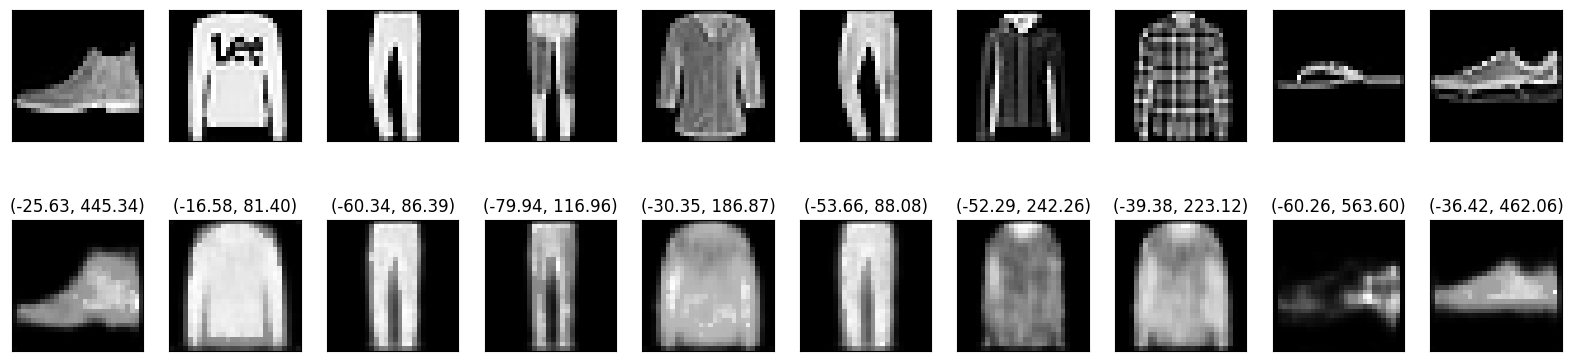

In [30]:
def get_triple(inputs, model):
    latent_repr = model.encoder(inputs.to(device))
    outputs = model.decoder(latent_repr.to(device)).cpu().detach().numpy()
    latent_repr = latent_repr.cpu().detach().numpy()
    print(latent_repr.shape)
    latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))

    return inputs, latent_repr, outputs

def show_encodings(inputs, latent_repr, outputs, title=None):
    n = len(inputs)
    fig, axes = plt.subplots(2, n, figsize=(2*n, 5))
    for i in range(n):
        axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if title:
        fig.suptitle(title)
    
show_encodings(*get_triple(x_test[:10], model2))

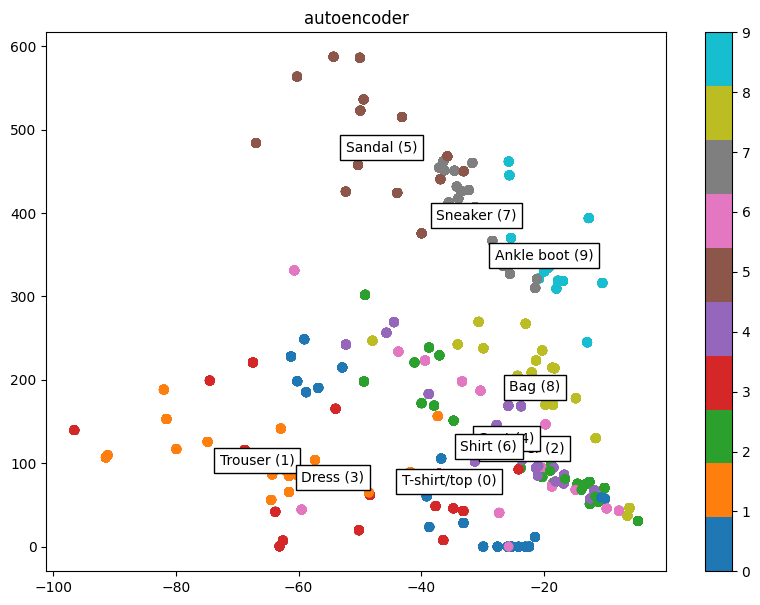

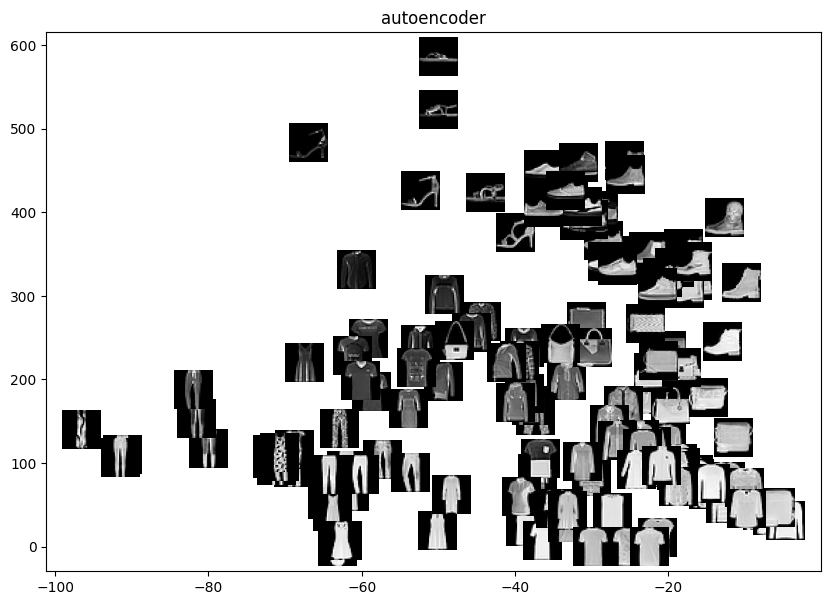

In [31]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea

labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def plot_latent(mode, count, technique):
    idx = np.random.choice(len(x_test), count)
    inputs = x_test[idx]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'autoencoder':
        coords = model2.encoder(inputs.to(device)).cpu().detach().numpy()

    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = y_test[idx]
        plt.scatter(coords[:, 0], coords[:, 1], c=classes, cmap='tab10')
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{} ({})'.format(labeldict[i], i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

plot_latent('dots', 10000, 'autoencoder')
plot_latent('imgs', 300, 'autoencoder')

## Пример 3. Денойзинг изображений.


In [32]:
noise_factor = 0.1
x_test_noisy  = torch.Tensor([x.numpy() + noise_factor * np.random.normal(size=x.shape) 
                              for x, y in testset ][:100])


Plot the noisy images.


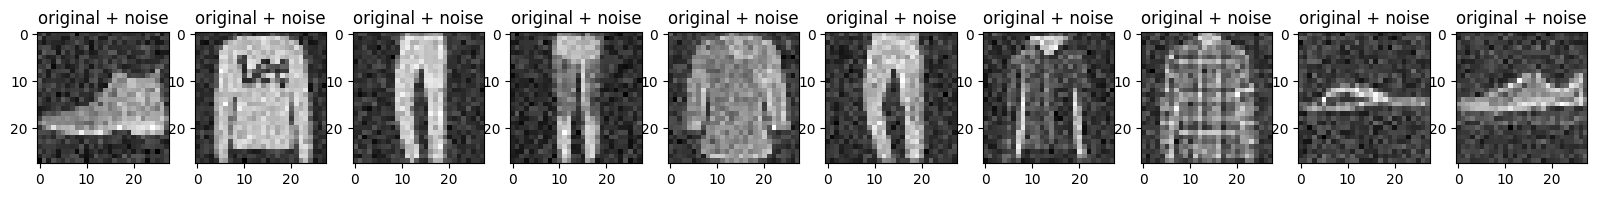

In [33]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(x_test_noisy[i][0])
    plt.gray()
plt.show()

In [34]:
encoded_imgs = model.encoder(x_test_noisy.to(device))
decoded_imgs = model.decoder(encoded_imgs).cpu().detach().numpy()
encoded_imgs = encoded_imgs.cpu().detach().numpy()

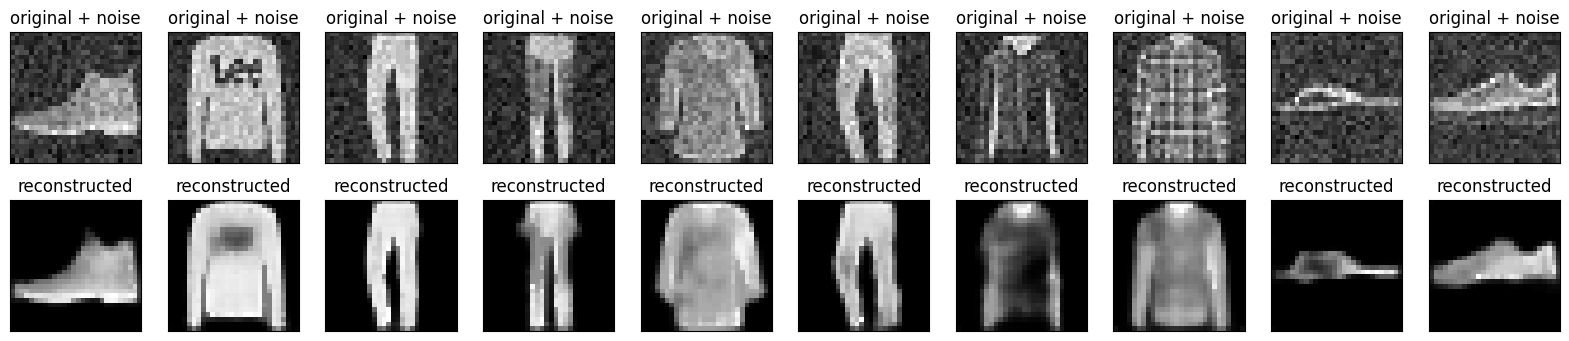

In [35]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(x_test_noisy[i][0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(decoded_imgs[i][0])
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Пример 4. Генерация изображений

(10, 2)


/tmp/ipykernel_85971/3304718668.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))


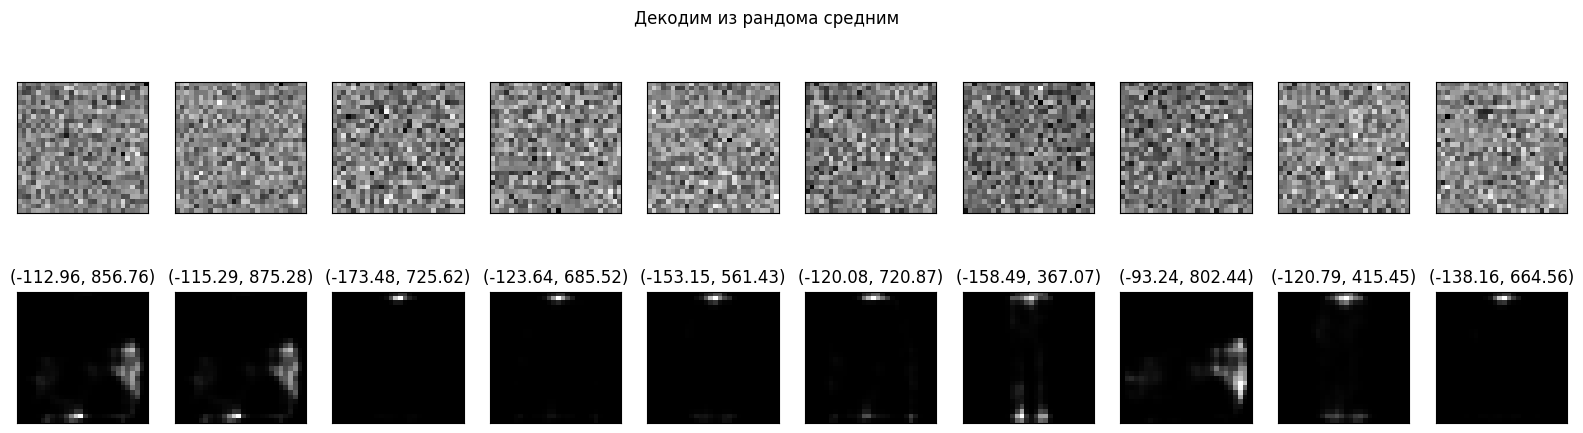

In [36]:
inputs = torch.Tensor(np.random.normal(loc=0, scale=1, size=(10, 1, 28, 28)))
show_encodings(*get_triple(inputs, model2), title='Декодим из рандома средним')

# Полезные ссылки

* Код написан по мотивам [блогпоста](https://javiferfer.medium.com/autoencoder-in-pytorch-for-the-fashion-mnist-dataset-66f4fb9465b4)